In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.chdir(".")

d1 = pd.read_csv("D1.txt", sep=" ", header=None)
d2 = pd.read_csv("D2.txt", sep=" ", header=None)
d3_leaves = pd.read_csv("D3leaves.txt", sep=" ", header=None)
dbig = pd.read_csv("Dbig.txt", sep=" ", header=None)
druns = pd.read_csv("Druns.txt", sep=" ", header=None)

## 1.

In [2]:
class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain #gain ratio
        self.value  = value

class DT():
    def __init__(self, min_samples=2, print=False, print_tree_str=False):
        self.min_samples = min_samples
        self.root = None 
        self.print = print
        self.print_tree_str = print_tree_str
        self.node_dict = {} #dict to store leaves


    def entropy(self,data_y):
        unique_y = np.unique(data_y)
        entropy = 0
        for y_i in unique_y:
            data_y_i = data_y[data_y == y_i]
            p_y_i = len(data_y_i)/len(data_y)
            entropy += -p_y_i*np.log2(p_y_i)
        return entropy


    # TODO: if there is a tie, break it arbitrarily?
    def gain_ratio(self,data, left_data, right_data):
        w_left = len(left_data)/len(data)
        w_right = len(right_data)/len(data)
        info_gain = self.entropy(data) - (w_left*self.entropy(left_data) + w_right*self.entropy(right_data))

        split_info = self.split_info(w_left, w_right)#-(w_left*np.log2(w_left) + w_right*np.log2(w_right))
        gr = info_gain / split_info 
        #### note: how is H_D(S) different from H_D(Y)??: H_D(S) is a split info, Hd(Y) stays constant throughout any candidate splits
        if self.print and gr == 0:
            return info_gain
        return gr 

    def split_info(self, p_left, p_right):
        return -(p_left*np.log2(p_left) + p_right*np.log2(p_right))


    def find_best_split(self,data):
        #dict storing the best splits 
        best_split = {"gain":-1, "x_i":None, "threshold":None, "data_left":None, "data_right":None}
        num_features = data.iloc[:,:-1].shape[1]
        labels = ["x1","x2"]
        for i in range(num_features):
            data_xi = data.iloc[:,i]
            xi_thresholds = np.argsort(data_xi)

            for xi_j in xi_thresholds: #loop over every unique value of x_i
                if xi_j == 0:
                    continue 
                if data.iloc[xi_j,-1] == data.iloc[xi_j-1,-1]:
                    continue

                xi_thres = data_xi.iloc[xi_j]
                data_left_xi_thres = data.loc[data.iloc[:,i] <= xi_thres,:]
                data_right_xi_thres = data.loc[data.iloc[:,i] > xi_thres,:]

                if len(data_left_xi_thres) > 0 and len(data_right_xi_thres) >0:
                    y = data.iloc[:,-1]
                    left_y = data_left_xi_thres.iloc[:,-1]
                    right_y = data_right_xi_thres.iloc[:,-1]
                    xi_thres_gain = self.gain_ratio(y, left_y, right_y)

                    # if the printing option is turned on 
                    if self.print:
                        print("Feature: ", labels[i], "Candidate split threshold: " ,xi_thres, "InfoGain: ", xi_thres_gain)


                    # if the entropy of the split is 0
                    if self.split_info(len(left_y)/len(y), len(right_y)/len(y)) == 0:
                        return None


                    # update if a better split is found 
                    if xi_thres_gain is not None and xi_thres_gain > best_split["gain"]:
                        best_split["gain"] = xi_thres_gain
                        best_split["x_i"] = i
                        best_split["threshold"] = xi_thres
                        best_split["data_left"] = data_left_xi_thres
                        best_split["data_right"] = data_right_xi_thres

        return best_split


    def get_leaf_value(self,data):
        if data is None:
            return None # when no data
            
        y = list(data.iloc[:,-1])
        if len(y) == 0:
            return None#default behavior when no data
        majority_y = max(y,key=y.count)
        majority_list = [y_i == majority_y for y_i in y]
        if len(majority_list) > len(data)/2:
            return majority_y

        # if the majority is not found, return 1 
        else:
            return 1

    
    ######
    ## given a feature index and the threshold of the best split, 
    ## returns leaf values for left and right side of the conditions
    def _check_left_or_right(self,data,feature_idx,threshold):
        data_feature_idx_y = data.iloc[:,[feature_idx,2]]
        left_data = data_feature_idx_y.loc[data_feature_idx_y.loc[:,feature_idx]<= threshold] #data where <= threshold 
        right_data = data_feature_idx_y.loc[data_feature_idx_y.loc[:,feature_idx]> threshold] #data where > threshold
        return self.get_leaf_value(left_data), self.get_leaf_value(right_data) #return leaves for both left and right conditions 



    # recursive 
    # data: a dataframe 
    # cond is a string of (x_i)>=(threshold) OR (x_i)<(threshold) format
    # feature_idx: either 0 or 1 denoting the index value of the feature x in the best split 
    # threshold: a numeric value of the best split 
    def _build(self, data, depth=0, cond=None, conditions=None, left_or_right=None):
        # if leaf
        # 1. empty node
        # 2. 0 gain ratio 
        # 3. entropy of any split is 0
        labels = ["x1","x2"]
        
        #STOPPING CRITERIA 1: If the leaf is empty(when predicting a new instance)
        if len(data) == 0: 
            if self.print_tree_str:
                print(cond," "*depth, "(",self.get_leaf_value(data),")")
            
            ##################### ADD LEAVES TO TRACKING DICT
            if cond is not None:
                if left_or_right == "left":
                    self.access_and_modify_nested_dict(self.node_dict, conditions,self.get_leaf_value(data))
                        #self.node_dict[cond]["left"] = self.get_leaf_value(data)
                else:
                    self.access_and_modify_nested_dict(self.node_dict, conditions,self.get_leaf_value(data))
                       # self.node_dict[cond]["right"] = self.get_leaf_value(data)

            return Node(value=self.get_leaf_value(data))

        # If the leaf is not empty 
        else:
            # Find the best split 
            best_split = self.find_best_split(data)

            # STOPPING CRITERIA 2 : If the gain ratio is 0 (when None is returned), then it is a leaf
            ####best split gr = -1 when everything is the same class 
            if best_split is None or best_split["gain"] == -1:
                if self.print_tree_str:
                    print(cond," "*depth,"(",self.get_leaf_value(data),")")

                ################### ADD LEAVES TO TRACKING DICT
                if cond is not None:
                    if left_or_right == "left":
                        self.access_and_modify_nested_dict(self.node_dict, conditions,self.get_leaf_value(data))
                        #self.node_dict[cond]["left"] = self.get_leaf_value(data)
                    else:
                        self.access_and_modify_nested_dict(self.node_dict, conditions,self.get_leaf_value(data))

                return Node(value=self.get_leaf_value(data))

            # STOPPING CRITERIA 3: If all splits have zero gain ratio
            if best_split["gain"] == 0:
                
                # print if printing is turned on 
                if self.print_tree_str:
                    print(cond," "*depth,"(",self.get_leaf_value(data),")")

                ################## ADD LEAVES TO TRACKING DICT 
                if cond is not None:
                    if left_or_right == "left":
                        self.access_and_modify_nested_dict(self.node_dict, conditions,self.get_leaf_value(data))
                        #self.node_dict[cond]["left"] = self.get_leaf_value(data)
                    else:
                        self.access_and_modify_nested_dict(self.node_dict, conditions,self.get_leaf_value(data))

                return Node(value=self.get_leaf_value(data))
            

            # RECURSIVE CALLS (CONDITIONS) : if the best split is not pure 
            if best_split["gain"] > 0:
                cond_split_left = labels[best_split["x_i"]] + "<=" + str(best_split["threshold"])
    
                if cond is not None:
                    new_conditions = conditions + [cond_split_left]
                   # print(self.node_dict)
                    if left_or_right == "left":
                        self.access_and_modify_nested_dict(self.node_dict,conditions,{cond_split_left:{"left":{},"right":{}}})
            
                    else:
                        self.access_and_modify_nested_dict(self.node_dict,conditions,{cond_split_left:{"left":{},"right":{}}})
    
                        
                else:
                    new_conditions = [cond_split_left]
                    self.node_dict[cond_split_left] = {"left":{},"right":{}}

                left_tree = self._build(best_split["data_left"], depth+1, cond_split_left, new_conditions + ["left"], "left")#best_split["x_i"], best_split["threshold"])
                right_tree = self._build(best_split["data_right"],depth+1, cond_split_left, new_conditions + ["right"], "right")#best_split["x_i"], best_split["threshold"])

                return Node(
                    feature=best_split["x_i"],
                    threshold=best_split["threshold"],
                    left=left_tree,
                    right=right_tree,
                    gain=best_split["gain"]
                )

    def delete_nested_dict_by_key(self,d, key_to_delete):
        if key_to_delete in d:
            del d[key_to_delete]
        else:
            for key, value in d.items():
                if isinstance(value, dict):
                    self.delete_nested_dict_by_key(value, key_to_delete)

    def access_and_modify_nested_dict(self,d, keys, new_value):
    # Base case: If there are no more keys to access, modify the value
        if len(keys) == 1:
            key = keys[0]
            if key in d:
                d[key] = new_value
            else:
                raise KeyError(f"Key '{key}' not found in the dictionary")
        else:
            key = keys[0]
            if key in d:
                self.access_and_modify_nested_dict(d[key], keys[1:], new_value)
            else:
                raise KeyError(f"Key '{key}' not found in the dictionary")


    def train(self,data):
        self.root = self._build(data)
        return self.node_dict

    def _predict_helper(self,built_tree,x):

        #leaf
        if built_tree.value != None:
            return built_tree.value

        x_feature = x.loc[built_tree.feature]

        #left subtree
        if x_feature <= built_tree.threshold:
            return self._predict_helper(built_tree.left, x=x)

        else:
            return self._predict_helper(built_tree.right, x=x)


    def predict(self,data_x):
        predicted = []
        for x in range(len(data_x)):
            predicted.append(self._predict_helper(self.root,data_x.iloc[x,:]))
        return predicted


## 2.2

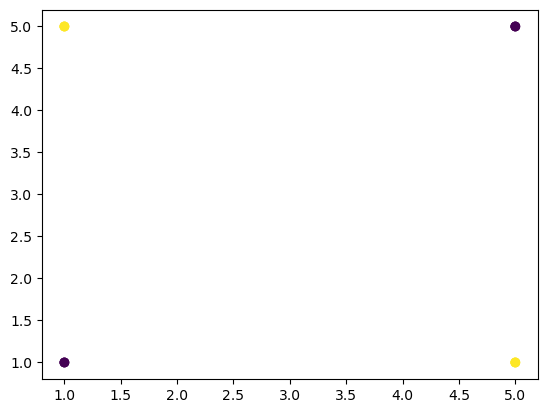

In [3]:
x1 = np.append(np.tile([1],6), np.tile([5],6))
x2 = np.tile([1,5],6)
y = np.append(np.tile([0,1],3),np.tile([1,0],3))

q22_data = pd.DataFrame({
    "x1":x1, 
    "x2":x2,
    "y":y
})

plt.scatter(x1,x2, c=y)


## 2.3

In [4]:
model23 = DT(print=True)
model23.train(druns) 

Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.10051807676021828
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.10051807676021828
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.10051807676021828
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.10051807676021828
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.10051807676021828
Feature:  x2 Candidate split threshold:  -1 InfoGain:  0.055953759631263526
Feature:  x2 Candidate split threshold:  0 InfoGain:  0.00578004220515232
Feature:  x2 Candidate split threshold:  6 InfoGain:  0.055953759631263526
Feature:  x2 Candidate split threshold:  7 InfoGain:  0.4301569161309807
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.07280247297910734
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.07280247297910734
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.07280247297910734
Feature:  x1 Candidate split threshold:  0.0 InfoGain:  0.07280247297910734
Feature:  x2 Candi

{'x2<=7': {'left': {'x2<=-1': {'left': {'x1<=0.0': {'left': 1, 'right': 0}},
    'right': {'x2<=6': {'left': 0, 'right': 0}}}},
  'right': 1}}

## 2.4
If x1 is less than or equal to 1, then classify as 0, else as 1. 

In [58]:
model24 =  DT(print=False,print_tree_str=False)
model24.train(d3_leaves)

{'x1<=1': {'left': 0, 'right': 1}}

## 2.5

In [59]:
modeld1 = DT(print=False, print_tree_str=False)
d1_dict = modeld1.train(d1)
d1_dict
# cond: x2<= n


{'x2<=0.199725': {'left': 0, 'right': 1}}

In [7]:
modeld2 = DT(print=False, print_tree_str=False)
d2_dict = modeld2.train(d2)
d2_dict

{'x1<=0.532664': {'left': {'x2<=0.881731': {'left': {'x2<=0.690829': {'left': {'x2<=0.501454': {'left': 0,
        'right': {'x1<=0.426073': {'left': {'x1<=0.409972': {'left': {'x1<=0.343437': {'left': 0,
              'right': {'x1<=0.409387': {'left': {'x2<=0.609262': {'left': 0,
                  'right': 1}},
                'right': 1}}}},
            'right': {'x1<=0.41206': {'left': 0,
              'right': {'x2<=0.570223': {'left': 0, 'right': 1}}}}}},
          'right': {'x2<=0.527033': {'left': 0, 'right': 1}}}}}},
      'right': {'x1<=0.254049': {'left': {'x1<=0.130649': {'left': 0,
          'right': {'x2<=0.827252': {'left': {'x2<=0.783115': {'left': 0,
              'right': {'x1<=0.178711': {'left': 0, 'right': 1}}}},
            'right': 1}}}},
        'right': 1}}}},
    'right': {'x1<=0.104094': {'left': {'x2<=0.917219': {'left': 0,
        'right': 1}},
      'right': 1}}}},
  'right': {'x2<=0.221983': {'left': {'x1<=0.830388': {'left': 0,
      'right': {'x2<=0.091

No, hard to interpret without visualization.

## 2.6

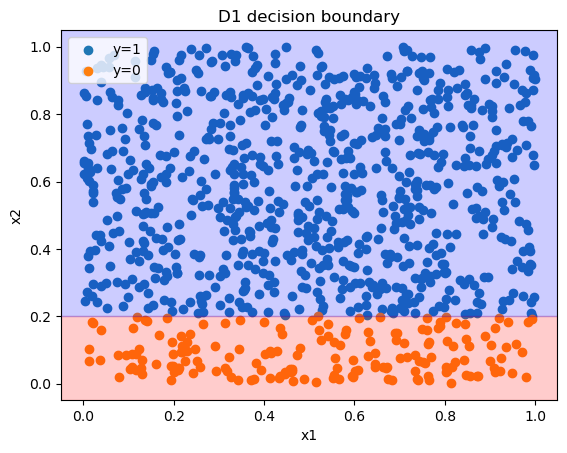

In [53]:
import copy
import re
from matplotlib.patches import Rectangle
from matplotlib.axes import Axes

def find_boundaries(tree_dict, ax):
  ax_xlim, ax_ylim = ax.get_xlim(), ax.get_ylim()
  whole_area = plt.Rectangle(xy=(ax_xlim[0],ax_ylim[0]), 
                            width= ax_xlim[1]-ax_xlim[0],
                            height = ax_ylim[1]-ax_ylim[0]
                            )
  bounds = _find_areas_helper(tree_dict,whole_area)
  return bounds
  
def _find_areas_helper(tree_dict, area):
    # if it's a leaf, color in and return the rectangle
    if isinstance(tree_dict, int):
        area = copy.deepcopy(area)
        if tree_dict == 1:
            area.set_color("blue")
            area.set_alpha(0.2)
        else:
            area.set_color("red")
            area.set_alpha(0.2)
        return [area]

    elif isinstance(tree_dict, dict): # if branch
        area_x1, area_x2 = copy.deepcopy(area), copy.deepcopy(area)
        
        # if the current run is at a splitting condition
        if "left" not in tree_dict.keys():
            cond = list(tree_dict.keys())[0]

            x1_le = r'x1<=(-?\d+\.\d+|\d+)'
            match = re.search(x1_le,cond)
            if match:
                x1_num = float(match.group(1))
                area_x1.set_x(x1_num) #left coordinate
                area_x1.set_width(area.get_width() - (x1_num - area.get_x()))
                area_x2.set_width(x1_num-area.get_x())

            x2_le = r'x2<=(-?\d+\.\d+|\d+)'
            match = re.search(x2_le,cond)
            if match:
                x2_num = float(match.group(1))
                area_x1.set_y(x2_num) #set bottom coord
                area_x1.set_height(area.get_height()-(x2_num-area.get_y()))
                area_x2.set_height(x2_num-area.get_y())

            next_tree_dict = tree_dict[cond]
            return _find_areas_helper(next_tree_dict["left"], area_x2) + _find_areas_helper(next_tree_dict["right"], area_x1)

        
        return _find_areas_helper(tree_dict["left"], area_x2) + _find_areas_helper(tree_dict["right"], area_x1)


def draw_decision_bounds(tree_dict, data, title):
        fig, ax = plt.subplots()
        data_ones, data_zeros = data[data.iloc[:,2] == 1], data[data.iloc[:,2] == 0]
        ax.scatter(data_ones.iloc[:,0],data_ones.iloc[:,1], label="y=1")
        ax.scatter(data_zeros.iloc[:,0],data_zeros.iloc[:,1], label="y=0")
        ax.legend()
        boundaries = find_boundaries(tree_dict,ax)
        for bound in boundaries:
            ax.add_patch(bound) 
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(title)
        
draw_decision_bounds(d1_dict, d1, "D1 decision boundary")

In [46]:
d1[d1.iloc[:,2] == 1]

,0,1,2
1,0.409499,0.213456,1
2,0.926224,0.540329,1
3,0.573685,0.282145,1
4,0.953159,0.608121,1
5,0.422326,0.844277,1
...,...,...,...
995,0.211320,0.737143,1
996,0.625005,0.233578,1
997,0.285166,0.956678,1
998,0.751571,0.514041,1


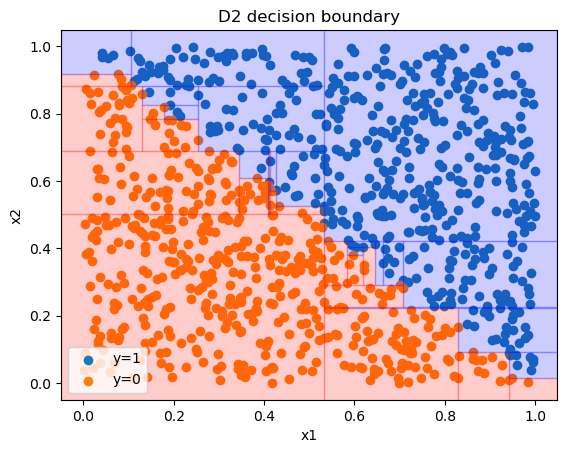

In [54]:
draw_decision_bounds(d2_dict, d2, "D2 decision boundary")

## 2.7

Number of nodes:  5
Err_n:  0.17975663716814158
Number of nodes:  13
Err_n:  0.07577433628318585
Number of nodes:  45
Err_n:  0.0625
Number of nodes:  106
Err_n:  0.023783185840707963
Number of nodes:  197
Err_n:  0.009402654867256638


Text(0, 0.5, 'Test err_n')

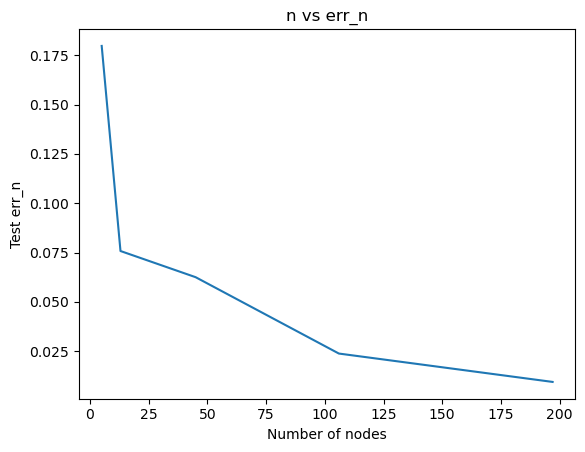

In [14]:
permuted_idx = np.random.permutation(10000)
train_indices = permuted_idx[:8192]
test_indices = permuted_idx[8192:10000]
train_data = dbig.iloc[train_indices]
test_data = dbig.iloc[test_indices]

train32 = train_data.loc[train_indices[:32]]
train128 = train_data.loc[train_indices[:128]]
train512 = train_data.loc[train_indices[:512]]
train2048 = train_data.loc[train_indices[:2048]]
train8192 = train_data.loc[train_indices[:8192]]

training_sets = [train32, train128, train512, train2048, train8192]
trained_dicts = []

def count_nodes_given_tree_dict(d):
    count = 0
    for key, value in d.items():
        if "<=" in key:
            count +=1
        if isinstance(value,dict):
            count += count_nodes_given_tree_dict(value)
    return count


training_sets = [train32, train128, train512, train2048, train8192]
test_x, test_y = test_data.iloc[:,[0,1]], test_data.iloc[:,2]
num_nodes, num_errs = [], []
for train_data in training_sets:
    model = DT(print=False, print_tree_str=False)
    trained_tree_dict = model.train(train_data)
    trained_dicts.append(trained_tree_dict)
    num_node = count_nodes_given_tree_dict(trained_tree_dict)
    num_nodes.append(num_node)
    print("Number of nodes: ", count_nodes_given_tree_dict(trained_tree_dict))
    y_hat = model.predict(test_x)
    num_err = sum(y_hat != test_y)/len(test_y)
    num_errs.append(num_err)
    print("Err_n: ", num_err)

plt.plot(num_nodes, num_errs)
plt.title("n vs err_n")
plt.xlabel("Number of nodes")
plt.ylabel("Test err_n")

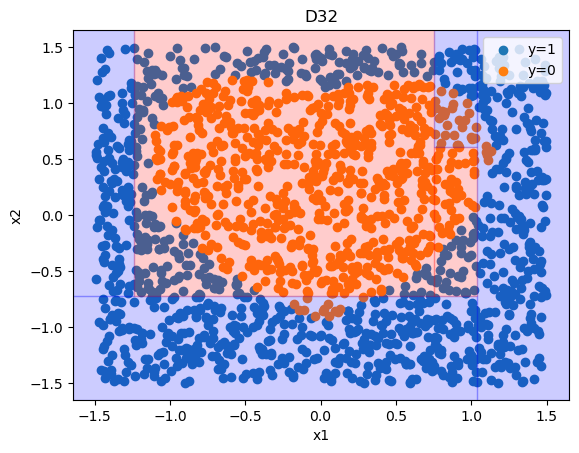

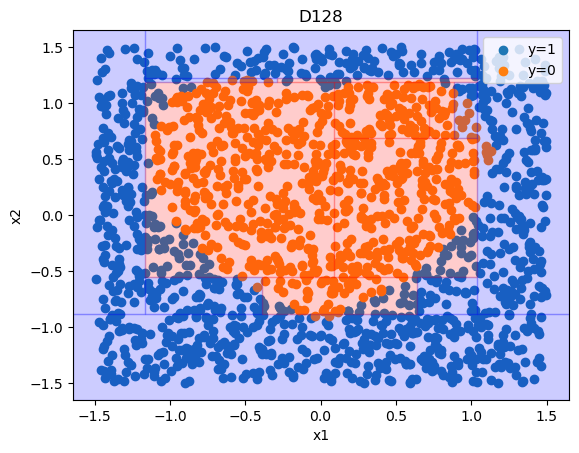

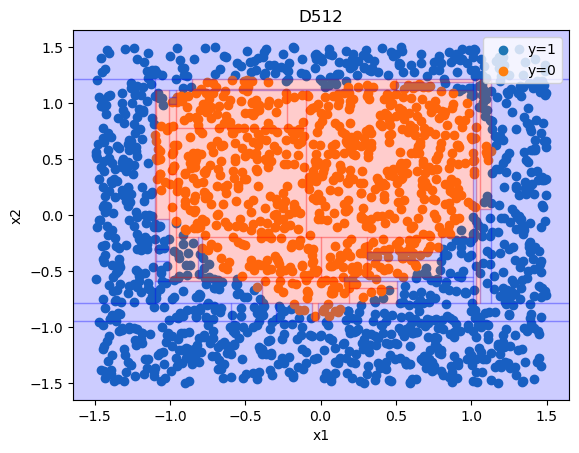

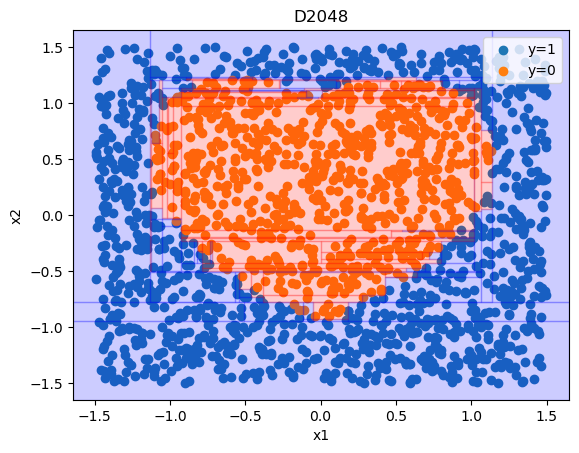

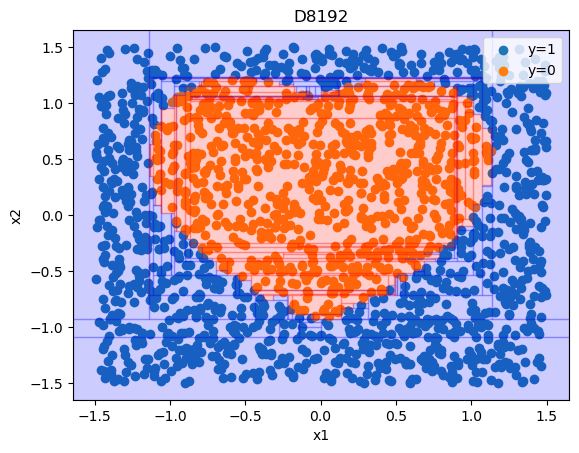

In [55]:
titles = ["D32","D128","D512","D2048","D8192"]
for i in range(len(trained_dicts)):
    draw_decision_bounds(trained_dicts[i], test_data, titles[i])

## 3.

Sk Number of nodes:  9
Sk Err_n:  0.07964601769911504
Sk Number of nodes:  25
Sk Err_n:  0.08130530973451328
Sk Number of nodes:  53
Sk Err_n:  0.04480088495575221
Sk Number of nodes:  129
Sk Err_n:  0.023783185840707963
Sk Number of nodes:  247
Sk Err_n:  0.009402654867256638


Text(0, 0.5, 'Test error rate')

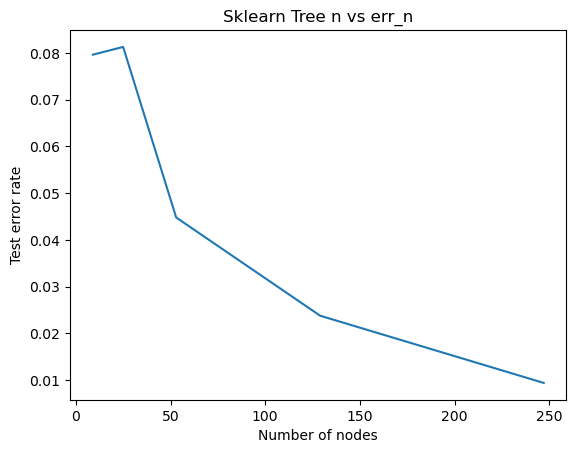

In [57]:
from sklearn import tree
sk_num_nodes, sk_num_errs = [], []
for train_data in training_sets:
    train_x, train_y = train_data.iloc[:,[0,1]], train_data.iloc[:,2]
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)

    num_node = model.tree_.node_count
    sk_num_nodes.append(num_node)
    print("Sk Number of nodes: ", num_node)

    y_hat = model.predict(test_x)
    num_err = sum(y_hat != test_y)/len(test_y)
    sk_num_errs.append(num_err)
    print("Sk Err_n: ", num_err)

plt.plot(sk_num_nodes, sk_num_errs)
plt.title("Sklearn Tree n vs err_n")
plt.xlabel("Number of nodes")
plt.ylabel("Test error rate")

## 4.

The Larange interpolation model over [0,30] with 100 points have 
868608.2054840629 training MSE and 340744.2914838607 test MSE. 

As the standard deviation of the Gaussian noise added to the training set x increases, both the training and the testing error get noisier. The MSE of the training and the testing error seem to be getting increasingly more unstable as the sd of the noise increases.

In [37]:
# params: a list of model parameter values  (a, b, n, max_degrees)
# noise_sds: a list of noise sd 
# noise_y: binary whether to add noise to the training set 
# 
# returns a training error and a test error 

from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
import random

def train_poly(params, noise_sd=None):
    random.seed(0)
    a, b, n, max_degrees = params
    train_errs, test_errs = 0, 0 #[], []
    train_x = np.random.uniform(a,b,n) 
    if noise_sd is not None:
        train_x += np.random.normal(0,noise_sd,n)
    test_x = np.random.uniform(a,b,n) 

    # partition into subsets of manageable degrees
    subsets = np.arange(a,n,n/max_degrees, dtype=int)
    for i in range(len(subsets)):
        low = subsets[i]
        up = int(low + n/max_degrees)

        #subset of TRAIN set 
        train_xi = train_x[low:up]
        train_yi = np.sin(train_xi)

        #subset of TEST set 
        test_xi = test_x[low:up]
        test_yi = np.sin(test_xi)
        
        # TRAIN
        poly_i = lagrange(train_xi, train_yi)
        y_hat_i = Polynomial(poly_i.coef[::-1])(train_xi)

        # TEST
        test_y_hat_i =  Polynomial(poly_i.coef[::-1])(test_xi)


        train_errs += np.mean((train_yi - y_hat_i)**2)
        test_errs += np.mean((test_yi - test_y_hat_i)**2)
    
    return train_errs, test_errs

a = 0
b = 30
n = 100
max_degrees = 5
train_poly((a,b,n,max_degrees), noise_sd=None)


(868608.2054840629, 340744.2914838607)

In [38]:
noise_sd = np.arange(0,1.1,step=0.01,dtype=float)
n_train_errs, n_test_errs = [], []
for sd in noise_sd:
    n_train_err, n_test_err = train_poly((a,b,n,max_degrees), noise_sd=sd)
    n_train_errs.append(n_train_err)
    n_test_errs.append(n_test_err)

Text(0, 0.5, 'log MSE')

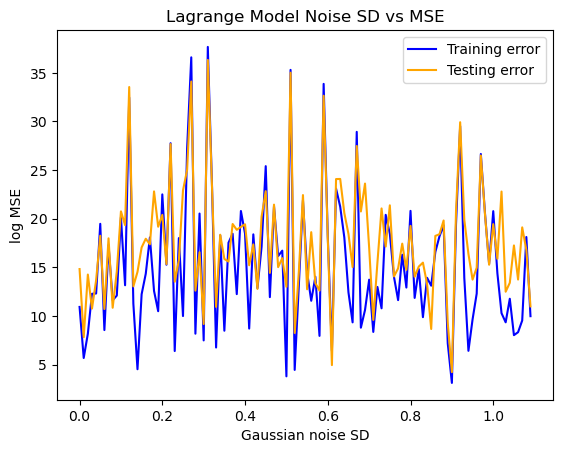

In [39]:
plt.plot(noise_sd, np.log(n_train_errs), color = "blue",label="Training error")
plt.plot(noise_sd, np.log(n_test_errs), color = "orange",label="Testing error")
plt.legend()
plt.title("Lagrange Model Noise SD vs MSE")
plt.xlabel("Gaussian noise SD")
plt.ylabel("log MSE")